In [2]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


# 2. Load Data

In [6]:
train = pd.read_csv('../Dataset/DailyDelhiClimateTrain.csv')
test = pd.read_csv('../Dataset/DailyDelhiClimateTest.csv')
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# 3. Initial Analysis

### 3.1. Metadata

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


In [6]:
print(f'Duplicate data : {train.duplicated().sum()}')

Duplicate data : 0


In [7]:
print(f'Null Data : \n{train.isna().sum()}')

Null Data : 
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


### 3.2. Procces Numerical and Categorical Columns

In [7]:
numerical_columns = [column_name for column_name in train.columns if train[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in train.columns if train[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'year', 'month', 'day']
Categorical Columns : []


In [8]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5
...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,28
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,29
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,30
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016,12,31


In [9]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test

,date,meantemp,humidity,wind_speed,meanpressure,year,month,day
0,2017-01-01,15.913043,85.869565,2.743478,59.000000,2017,1,1
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778,2017,1,2
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333,2017,1,3
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000,2017,1,4
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333,2017,1,5
...,...,...,...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000,2017,4,20
110,2017-04-21,34.250000,39.375000,6.962500,999.875000,2017,4,21
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000,2017,4,22
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000,2017,4,23


In [10]:
numerical_columns = [column_name for column_name in train.columns if train[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in train.columns if train[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure', 'year', 'month', 'day']
Categorical Columns : []


### 3.3. EDA

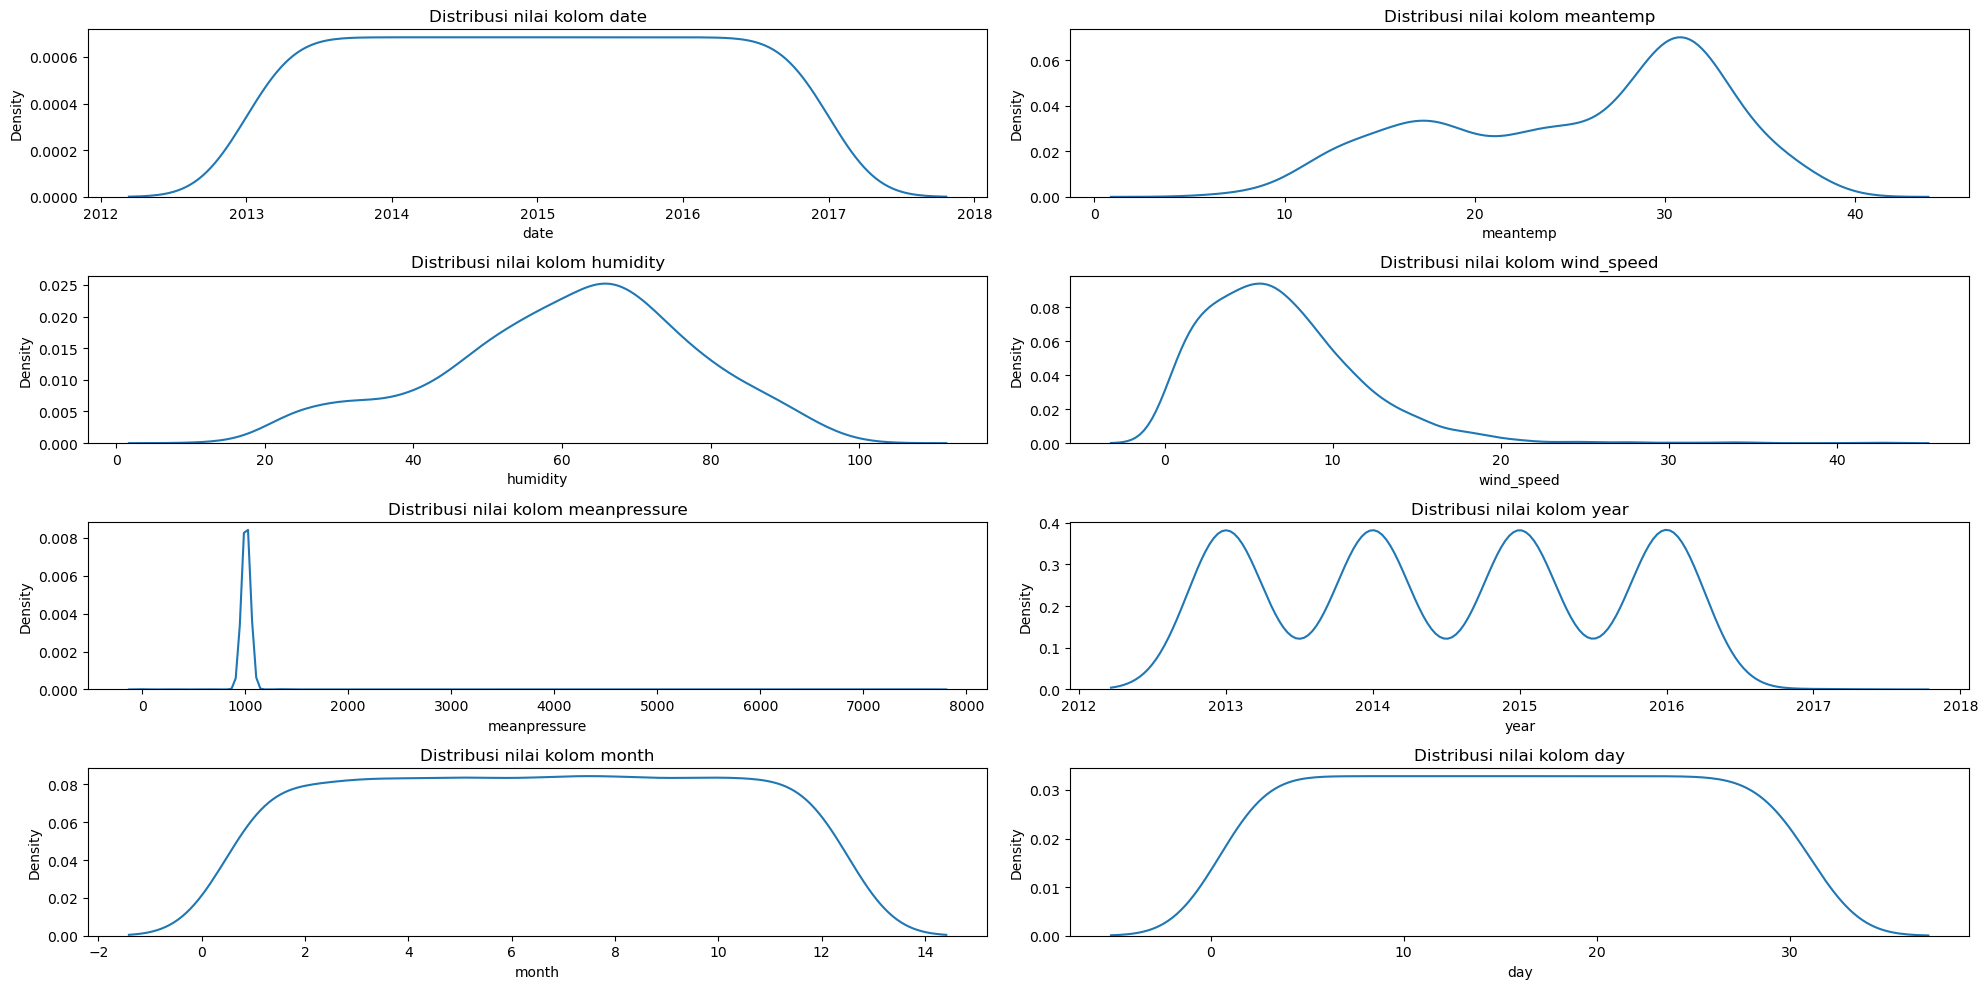

In [44]:
num_cols = 2
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = train, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

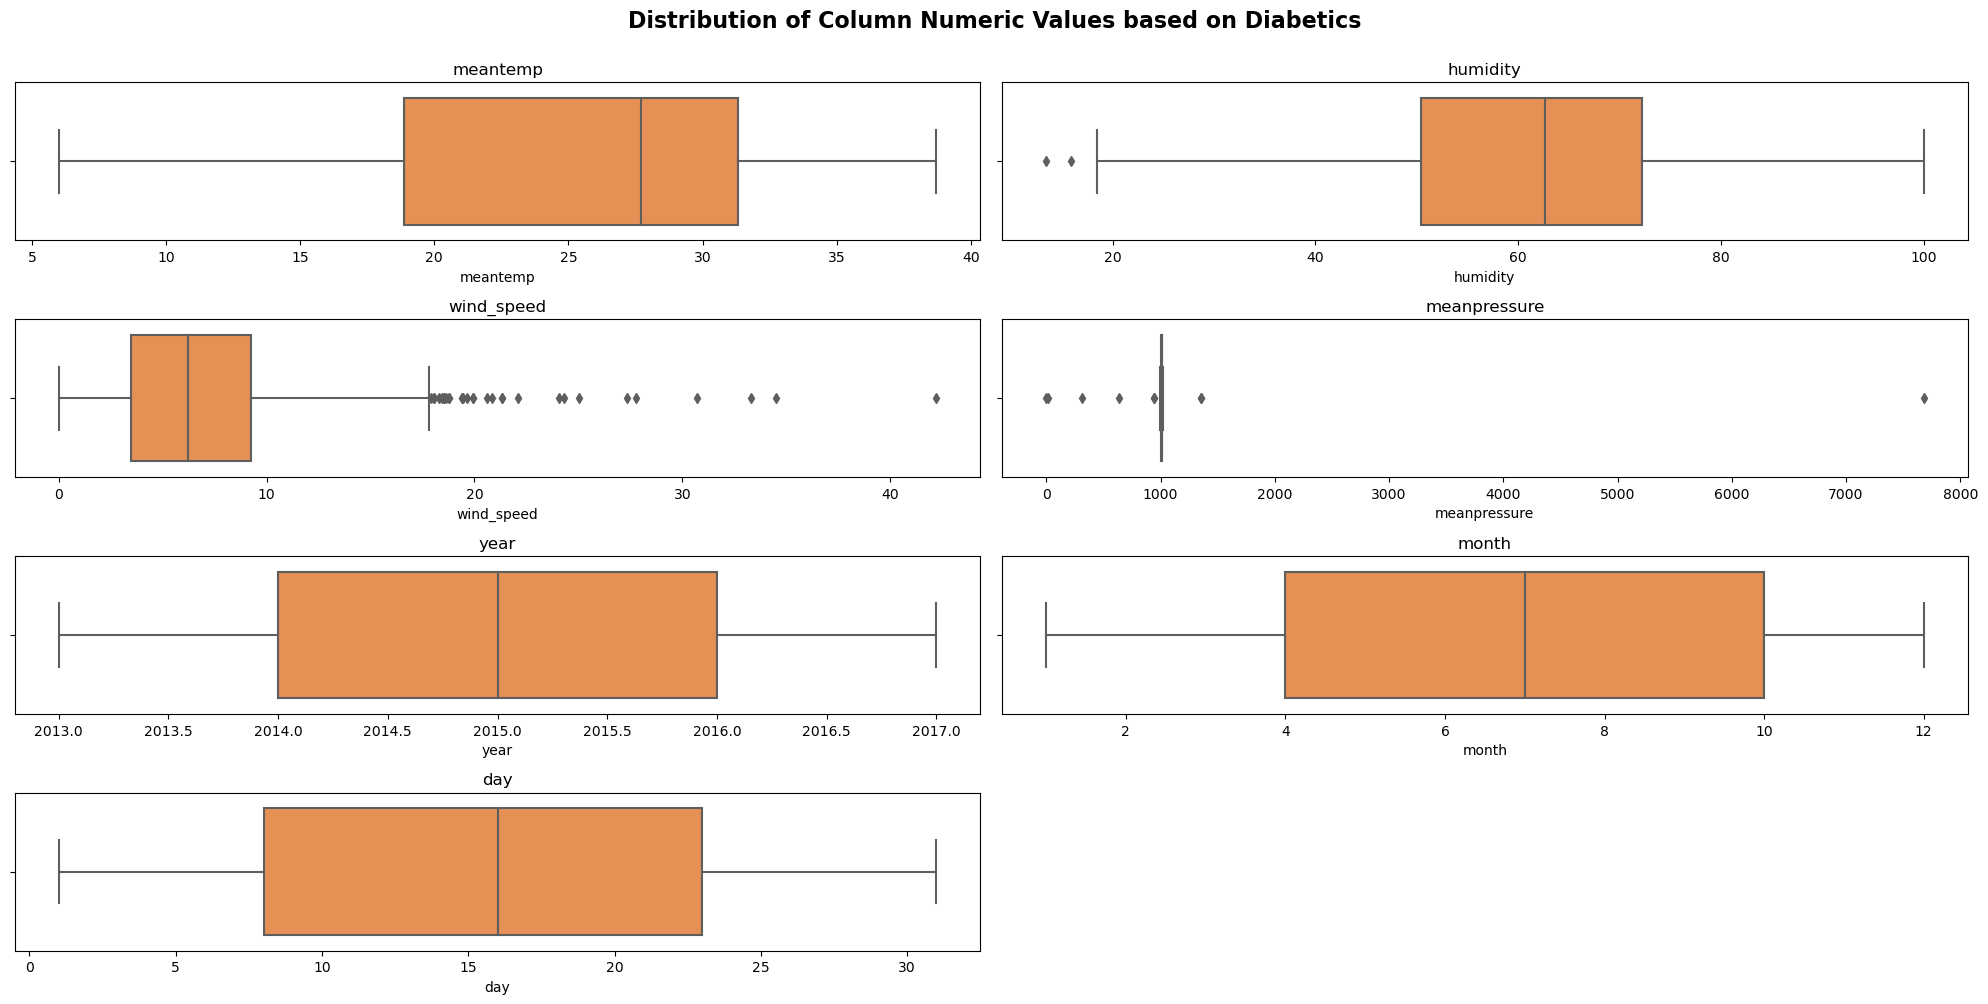

In [49]:
plot_columns = numerical_columns[1:]

num_cols = 2
num_rows = math.ceil(len(plot_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(plot_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=train[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(plot_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

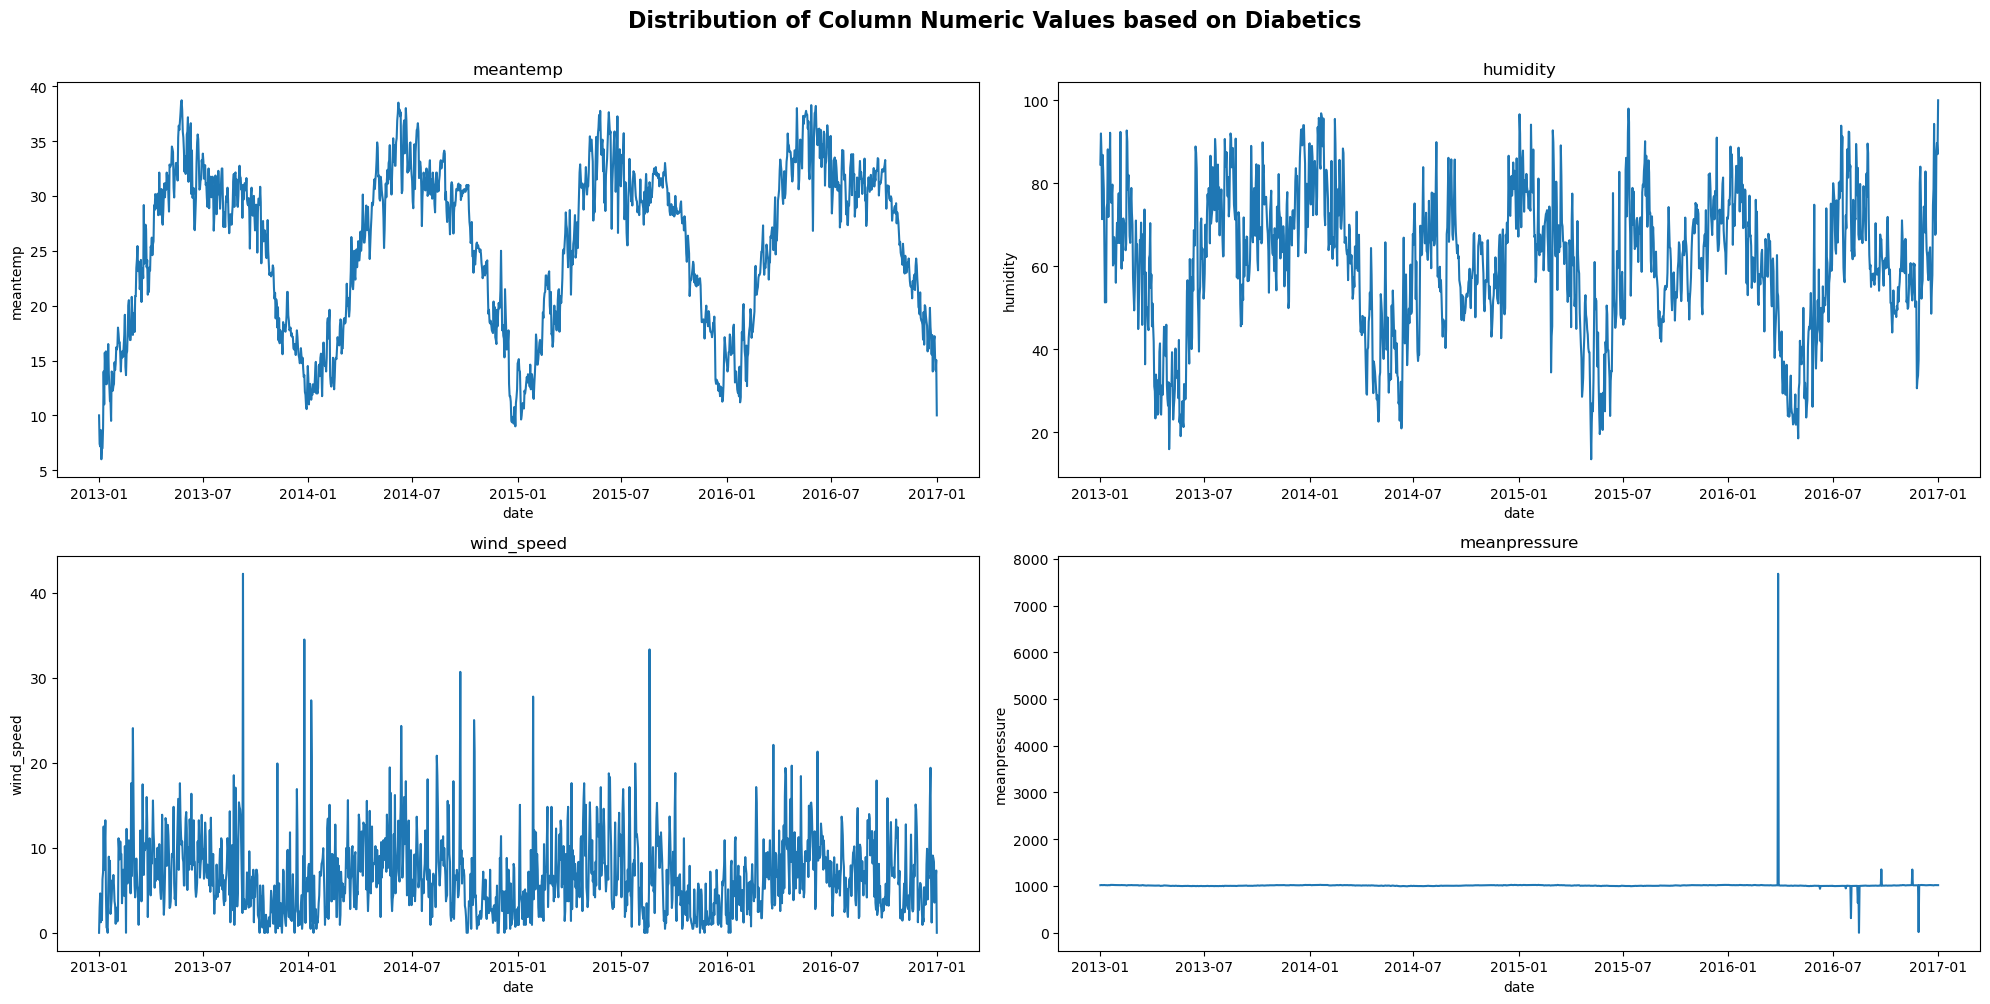

In [58]:
plot_columns = numerical_columns[1:5]

num_cols = 2
num_rows = math.ceil(len(plot_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(plot_columns):
    row = i // num_cols
    col = i % num_cols
    sns.lineplot(data = train, x=train['date'], y = train[column],ax=axes[row, col]).set_title(column)
    
for i in range(len(plot_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Diabetics', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.4. Data Correlations

C:\Users\indiz\AppData\Local\Temp\ipykernel_2868\904363544.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_data = train.corr().round(2)


Text(0.5, 1.0, 'Correlation Matrix')

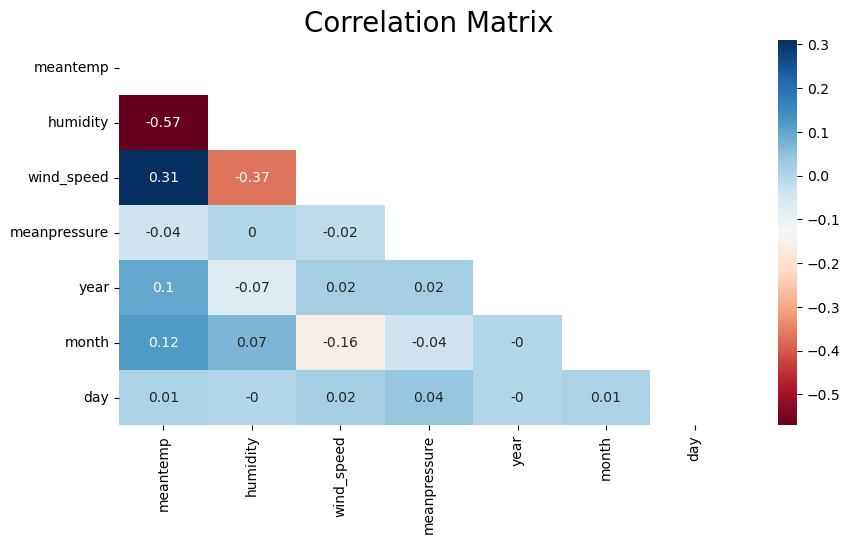

In [11]:
corr_data = train.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
plt.figure(figsize=(10, 5))
sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Regression Algorithm

In [75]:
X_train = train.drop(columns=['meantemp', 'date']).values
y_train = train['meantemp'].values

X_test = test.drop(columns=['meantemp', 'date']).values
y_test = test['meantemp'].values

scalar = PowerTransformer(method='yeo-johnson', standardize=True).fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [76]:
adaboost = AdaBoostRegressor(n_estimators=100, random_state=42)
bagging = BaggingRegressor(n_jobs=-1)
extraTrees = ExtraTreesRegressor(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingRegressor(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=0)
randomForest = RandomForestRegressor(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs=-1)
knn = KNeighborsRegressor( n_jobs=-1)
decisionTree = DecisionTreeRegressor(random_state=42, max_depth=100)

model = StackingRegressor([
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('gradient', gradient),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB),
    ('knn', knn),
    ('decisionTree', decisionTree),

], n_jobs=-1)

In [77]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('extraTress',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('gradient',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         max_depth=100,
                                                         random_state=0)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('knn', KNeighborsRegressor(n_jobs=-1)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42))],
                  n_jobs=-1)

In [82]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    : ",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error : ",round(mean_squared_error(y_test, y_pred), 2))

Train Score :  99.57 %
Test Score  :  77.2 %
R Squared Error    :  0.77
Mean Squared Error :  9.14


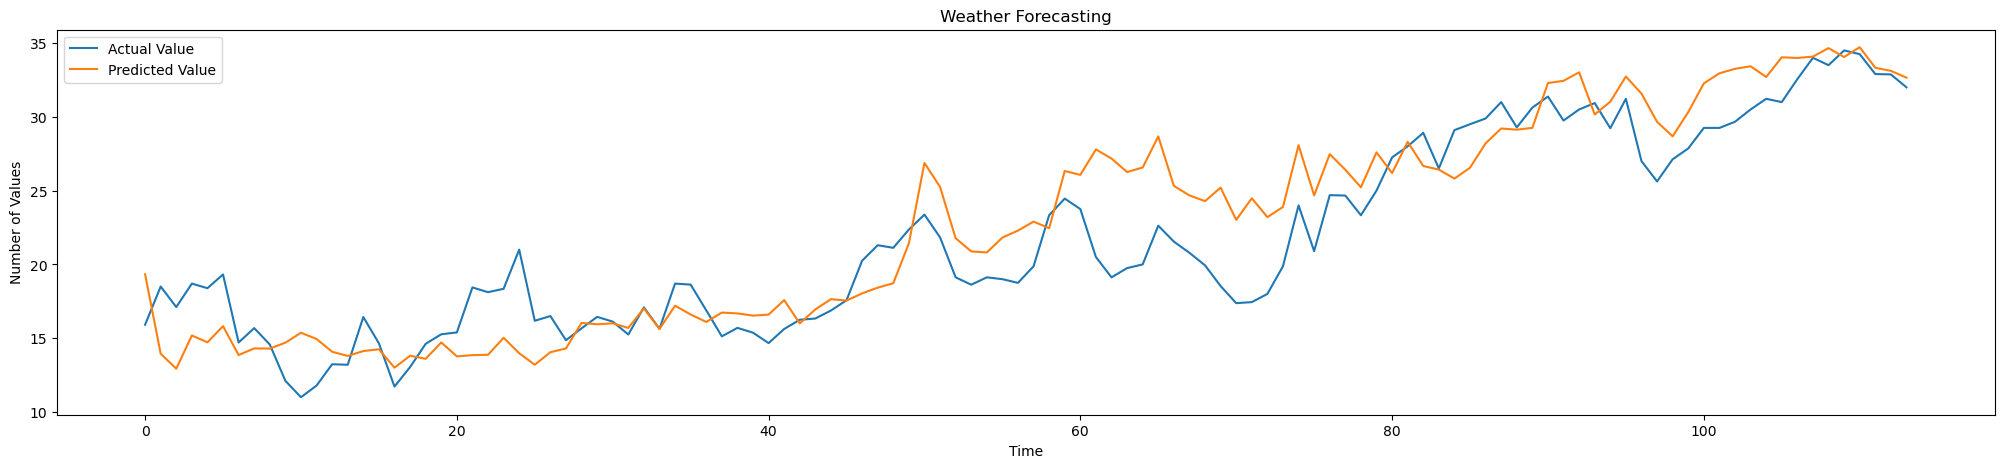

In [83]:
y_pred = model.predict(X_test)

fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(y_test, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.title('Weather Forecasting')
plt.ylabel('Number of Values')
plt.xlabel('Time')
plt.legend()
plt.show()

# 5. Neural Network Model

In [97]:
humid_train = train['meantemp']
humid_test = test['meantemp']

<Axes: xlabel='date', ylabel='meantemp'>

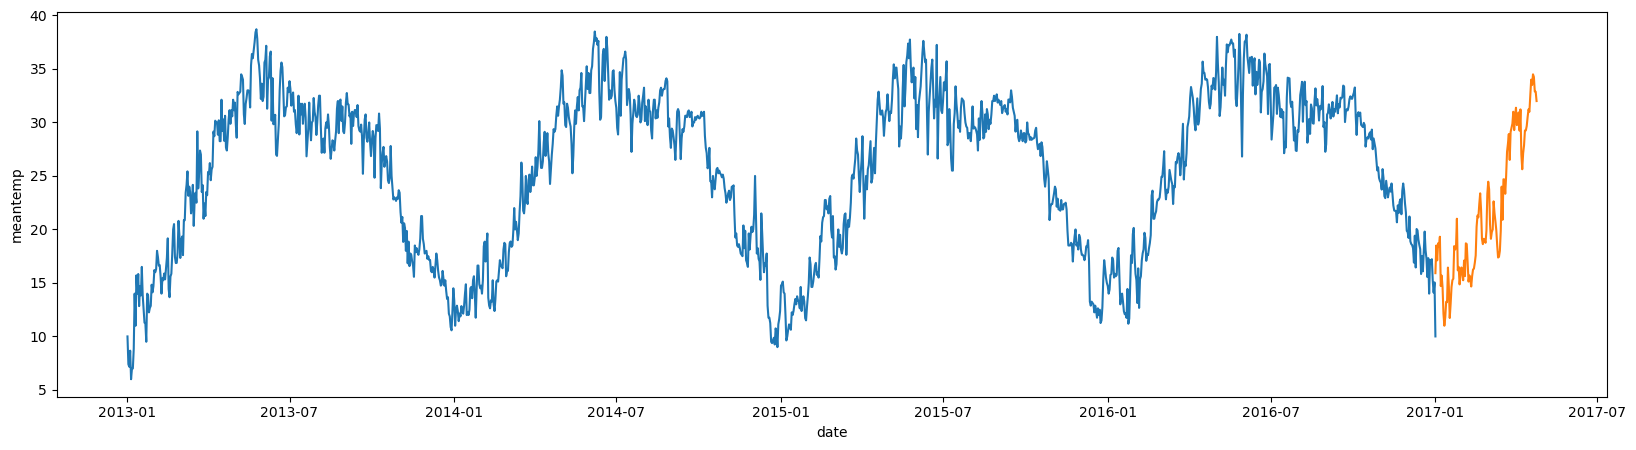

In [94]:
plt.subplots(figsize=(20,5))
sns.lineplot(data = train, x=train['date'], y = train['meantemp'])
sns.lineplot(data = train, x=test['date'], y = test['meantemp'])

In [104]:
def create_dataset(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [105]:
WINDOW_SIZE = 100
X_train, y_train = create_dataset(humid_train, WINDOW_SIZE)
X_test, y_test = create_dataset(humid_test, WINDOW_SIZE)
X_train.shape, y_train.shape

((1362, 100, 1), (1362,))

In [140]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

# model = DNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.0001)

# model.compile(loss='mse', optimizer=opt, metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 100, 256)          198912    
                                                                 
 gru_11 (GRU)                (None, 128)               148224    
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 371,969
Trainable params: 371,969
Non-trainable params: 0
_________________________________________________________________


In [141]:
num_epoch = 100
batch_size = 32

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history = model.fit(X_train, y_train, 
                    batch_size = batch_size, epochs = num_epoch,
                    validation_split = 0.2, shuffle=False, verbose = 2,
                    callbacks = [reduce_lr])

Epoch 1/100
35/35 - 3s - loss: 611.5258 - mse: 611.5258 - val_loss: 686.6181 - val_mse: 686.6181 - lr: 1.0000e-04 - 3s/epoch - 87ms/step
Epoch 2/100
35/35 - 1s - loss: 438.5131 - mse: 438.5131 - val_loss: 497.4433 - val_mse: 497.4433 - lr: 1.0000e-04 - 801ms/epoch - 23ms/step
Epoch 3/100
35/35 - 1s - loss: 293.6096 - mse: 293.6096 - val_loss: 331.2092 - val_mse: 331.2092 - lr: 1.0000e-04 - 782ms/epoch - 22ms/step
Epoch 4/100
35/35 - 1s - loss: 178.6104 - mse: 178.6104 - val_loss: 202.6637 - val_mse: 202.6637 - lr: 1.0000e-04 - 789ms/epoch - 23ms/step
Epoch 5/100
35/35 - 1s - loss: 104.9052 - mse: 104.9052 - val_loss: 120.3338 - val_mse: 120.3338 - lr: 1.0000e-04 - 770ms/epoch - 22ms/step
Epoch 6/100
35/35 - 1s - loss: 68.7466 - mse: 68.7466 - val_loss: 77.8898 - val_mse: 77.8898 - lr: 1.0000e-04 - 768ms/epoch - 22ms/step
Epoch 7/100
35/35 - 1s - loss: 55.7801 - mse: 55.7801 - val_loss: 59.8766 - val_mse: 59.8766 - lr: 1.0000e-04 - 813ms/epoch - 23ms/step
Epoch 8/100
35/35 - 1s - loss: 

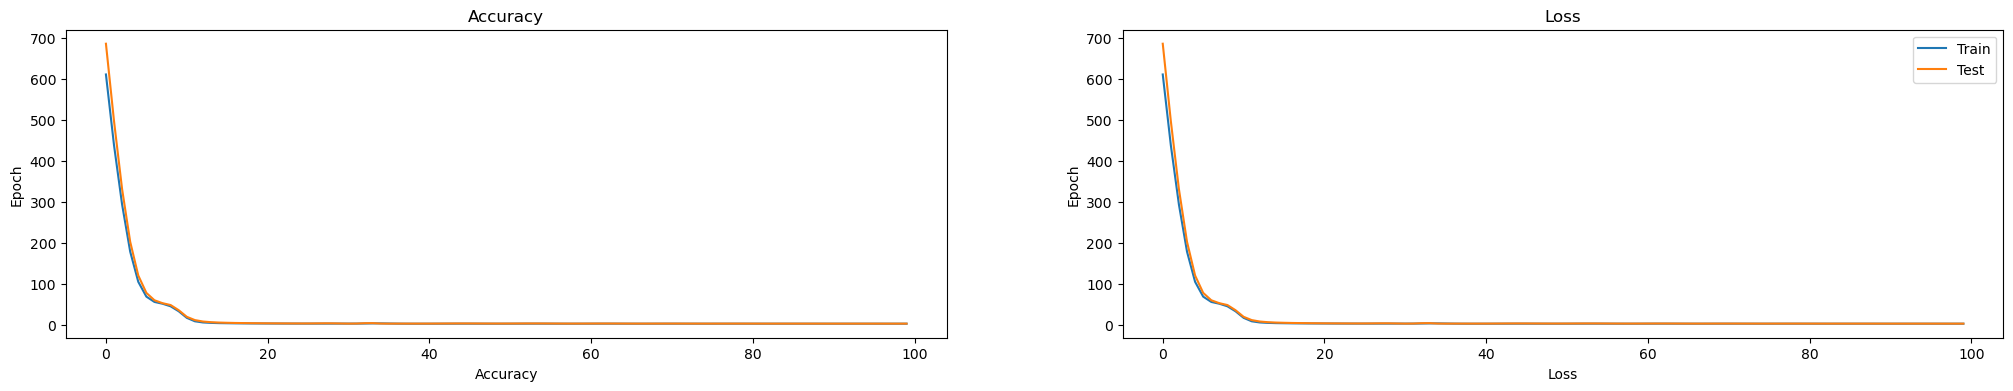

In [142]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['mse'])
ax[0].plot(history.history['val_mse'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [143]:
train_predictions = model.predict(X_test).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = train_results['Actuals'] - train_results['Train Predictions']
train_results

1/1 [==============================] - 0s 387ms/step


,Train Predictions,Actuals,Diff
0,28.236179,29.250000,1.013821
1,29.296021,29.250000,-0.046021
2,29.360786,29.666667,0.305880
3,29.747643,30.500000,0.752357
4,30.579170,31.222222,0.643052
5,31.192850,31.000000,-0.192850
6,31.017179,32.555556,1.538376
7,32.354153,34.000000,1.645847
8,33.407284,33.500000,0.092716
9,33.016605,34.500000,1.483395


1/1 [==============================] - 0s 20ms/step


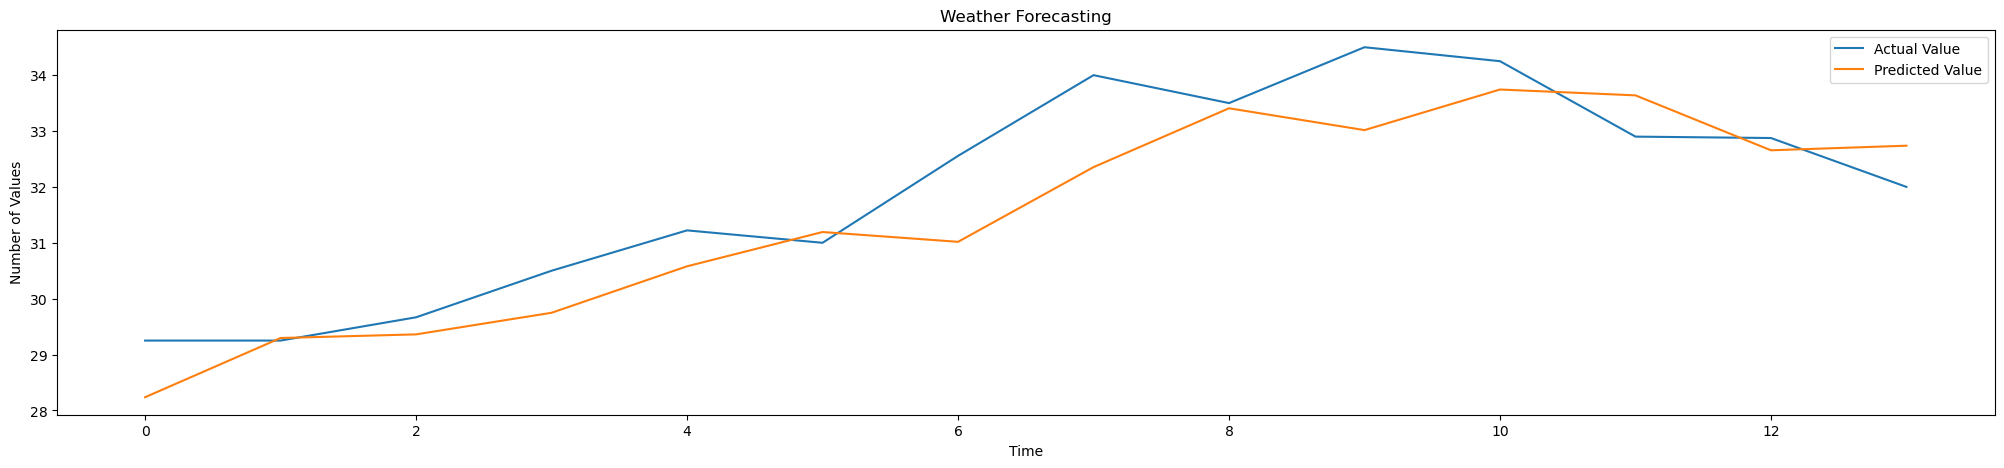

In [144]:
y_pred = model.predict(X_test)

fig, ax = plt.subplots(figsize=(25, 5))

plt.plot(y_test, label = 'Actual Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.title('Weather Forecasting')
plt.ylabel('Number of Values')
plt.xlabel('Time')
plt.legend()
plt.show()

# 6. Prophet

In [12]:
forecast_data = train.rename(columns = {"date": "ds", 
                                       "meantemp": "y"})
forecast_data

,ds,y,humidity,wind_speed,meanpressure,year,month,day
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5
...,...,...,...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,28
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,29
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,30
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016,12,31


In [13]:
model = Prophet()
model.fit(forecast_data)

14:10:58 - cmdstanpy - INFO - Chain [1] start processing
14:10:58 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
forecasts = model.make_future_dataframe(periods=365)
predictions = model.predict(forecasts)
plot_plotly(model, predictions)